In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [13]:
# Configuration
base_dir = "/scicore/home/schwede/pudziu0000/projects/gLM/logs/gLM.models.PredictorPPI/PINDER/eubacteria_5_1024_512_species_heterodimers/"
representations = ["joint_pooling", "separate_pooling", "joint_input_separate_pooling"]
biolms = ["gLM2", "ESM2", "MINT"]
metric_of_interest = "accuracy"  # Change to 'roc_auc', 'pr_auc', etc. if needed
num_folds = 5        # Set the actual number of folds

In [3]:
def get_accuracy(row):
    tp = row["tp"].values[0]
    tn = row["tn"].values[0]
    fp = row["fp"].values[0]
    fn = row["fn"].values[0]
    denom = tp + tn + fp + fn
    metric_value = (tp + tn) / denom if denom > 0 else 0.0
    return metric_value

joint_pooling_gLM2	18
joint_pooling_gLM2	9
joint_pooling_gLM2	3
joint_pooling_gLM2	12
joint_pooling_gLM2	16
joint_pooling_ESM2	17
joint_pooling_ESM2	20
joint_pooling_ESM2	23
joint_pooling_ESM2	17
joint_pooling_ESM2	17
joint_pooling_MINT	0
joint_pooling_MINT	0
joint_pooling_MINT	1
joint_pooling_MINT	0
joint_pooling_MINT	0
separate_pooling_gLM2	8
separate_pooling_gLM2	7
separate_pooling_gLM2	0
separate_pooling_gLM2	6
separate_pooling_gLM2	18
separate_pooling_ESM2	13
separate_pooling_ESM2	10
separate_pooling_ESM2	15
separate_pooling_ESM2	8
separate_pooling_ESM2	15
separate_pooling_MINT	71
separate_pooling_MINT	4
separate_pooling_MINT	26
separate_pooling_MINT	0
separate_pooling_MINT	0
joint_input_separate_pooling_gLM2	10
joint_input_separate_pooling_gLM2	24
joint_input_separate_pooling_gLM2	17
joint_input_separate_pooling_gLM2	21
joint_input_separate_pooling_gLM2	20
joint_input_separate_pooling_ESM2	12
joint_input_separate_pooling_ESM2	11
joint_input_separate_pooling_ESM2	8
joint_input_sep

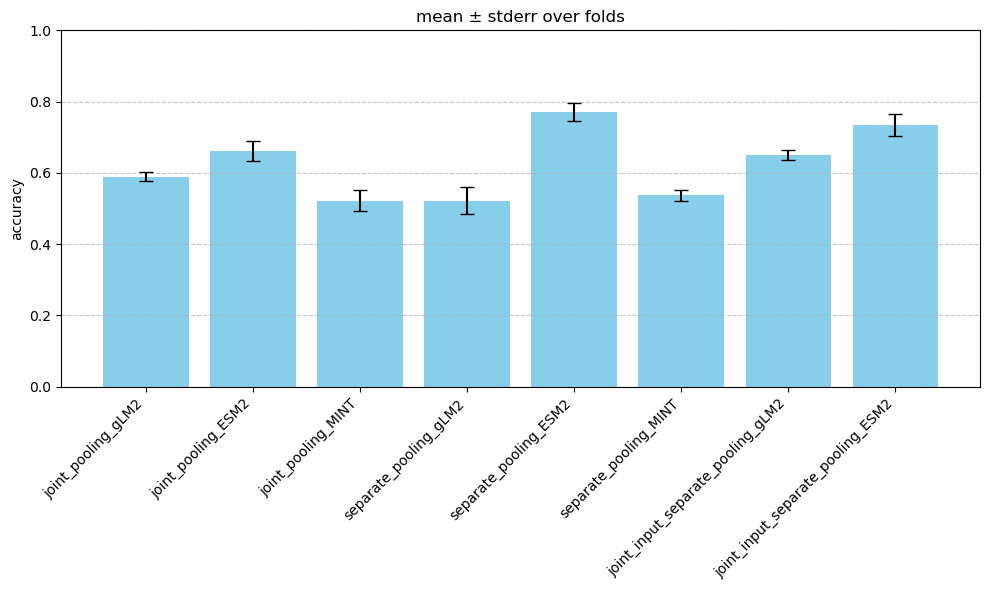

In [19]:
# Container for results
experiment_results = {}

for representation in representations:
    for biolm in biolms:
        fold_metrics = []
        for fold_num in range(num_folds):
            # Define paths
            fold_path = f"{base_dir}/{representation}/{biolm}/{fold_num}"
            ckpt_path = glob(f"{fold_path}/checkpoints/model-epoch=*.ckpt")
    
            if not ckpt_path:
                print(f"No checkpoint found for {representation}/{biolm}, fold {fold_num}")
                continue
            
            # Extract best epoch
            match = re.search(r"model-epoch=(\d+)\.ckpt", os.path.basename(ckpt_path[0]))
            if not match:
                print(f"Could not extract epoch from checkpoint for {representation}/{biolm}, fold {fold_num}")
                continue
            best_epoch = int(match.group(1))
    
            # Read metrics
            metrics_file = os.path.join(fold_path, "metrics.csv")
            if not os.path.isfile(metrics_file):
                print(f"No metrics.csv found for exp {representation}/{biolm}, fold {fold_num}")
                continue
            df = pd.read_csv(metrics_file)
    
            # Drop the first duplicate line of epoch 0
            df = df[~((df.epoch == 0) & (df.index == df[df.epoch == 0].index.min()))]
    
            # Get metric at best epoch
            row = df[df.epoch == best_epoch]
            if row.empty:
                print(f"No data for best epoch {best_epoch} in {representation}/{biolm}, fold {fold_num}")
                continue
    
            if metric_of_interest == "accuracy":
                required_cols = {"tn", "fp", "fn", "tp"}
                if not required_cols.issubset(row.columns):
                    print(f"Missing columns for accuracy in {representation}/{biolm}, fold {fold_num}")
                    continue
                metric_value = get_accuracy(row)
            else:
                metric_value = row[metric_of_interest].values[0]
            fold_metrics.append(metric_value)
    
        if fold_metrics:
            experiment_results[f"{representation}_{biolm}"] = fold_metrics

# Plotting
means = []
stderrs = []
labels = []

for model_type, metrics in experiment_results.items():
    mean_val = sum(metrics) / len(metrics)
    stderr_val = pd.Series(metrics).std()#/len(metrics)**(1/2)
    means.append(mean_val)
    stderrs.append(stderr_val)
    labels.append(f"{model_type}")

# Create bar plot with error bars
plt.figure(figsize=(10, 6))
plt.bar(labels, means, yerr=stderrs, capsize=5, color='skyblue')
plt.ylabel(metric_of_interest)
plt.xticks(rotation=45, ha='right')
plt.title(f"mean ± stderr over folds")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
